# Stock Bond Gerber

## Packages

In [1]:
import os
import sys
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Path Management

In [7]:
gerber_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
packages_path = os.path.join(os.path.abspath(os.path.join(gerber_path, os.pardir)))
streamlit_path = os.path.join(packages_path, "streamlit")
backend_tools_path = os.path.join(streamlit_path, "backend_tools")
data_manager_path = os.path.join(backend_tools_path, "data_manager")
out_data_path = os.path.join(data_manager_path, "out")
fund_master_path = os.path.join(out_data_path, "equity_master_daily_sample.parquet")

In [8]:
df = (pd.read_parquet(
    path = fund_master_path,
    engine = "pyarrow").
    query("ticker_type == 'Close'").
    drop(columns = ["ticker_type", "rtns", "log_rtns"]).
    pivot(index = "Date", columns = "ticker", values = "value").
    pct_change())

## Matrix

In [90]:
class Matrix: 
    
    def __init__(self, rtns: pd.DataFrame, threshold_constant: float = None, method: str = None, verbose = True):
        
        self.threshold_constant = 1/2
        self.method = "method1"
        
        if threshold_constant == None:
            if verbose == True: print("No Threshold Constant passed, using default 1/2")
            threshold_constant = self.threshold_constant
            
        if method == None:
            if verbose == True: print("No Method Passed, using default Method 1")
            method = self.method

        hk = (rtns.std().reset_index().rename(
            columns = {0: "std_dev"}).
            assign(
                ck = threshold_constant,
                h_k = lambda x: x.ck * x.std_dev)
            [["ticker", "h_k"]])

        threshold_df = (rtns.reset_index().melt(
                id_vars = "Date").
                merge(hk, how = "outer", on = "ticker").
                rename(columns = {"value": "rtns"}))

        if method == "method1":

            R = threshold_df.rename(columns = {"h_k": "h_j"})
            U = R
            U.loc[(U["rtns"] >= U["h_j"]), "u_tj"] = 1
            U = U.fillna(0)[["Date", "ticker", "u_tj"]].pivot(index = "Date", columns = "ticker", values = "u_tj")

            D = R
            D.loc[(D["rtns"] <= - D["h_j"]), "d_tj"] = 1
            D = D.fillna(0)[["Date", "ticker", "d_tj"]].pivot(index = "Date", columns = "ticker", values = "d_tj")

            N_UU = U.T.dot(U)
            N_DD = D.T.dot(D)

            N_conc = N_UU + N_DD
            N_disc = U.T.dot(D) + D.T.dot(U)

            g_matrix = (N_conc - N_disc).divide(N_conc + N_disc)

        if method == "method2":

            combinations = list(itertools.combinations(rtns.columns.to_list(),2))
            m_ij = pd.DataFrame(columns = ["Date", "m_ij", "ticker1", "ticker2"]).set_index("Date")
            gerber_stat = pd.DataFrame(columns = ["ticker1", "ticker2", "gerber_stat"])

            for combo in combinations:

                returns_tmp = (threshold_df[["Date", "ticker", "rtns"]].query(
                    "ticker == @combo[0] | ticker == @combo[1]").
                     pivot(index = "Date", columns = "ticker", values = "rtns").
                     rename(columns = 
                            {combo[0]: "{}_rtns".format(combo[0]), 
                             combo[1]: "{}_rtns".format(combo[1])}))

                hk_rtmp = (threshold_df[["Date", "ticker", "h_k"]].query(
                    "ticker == @combo[0] | ticker == @combo[1]").
                     pivot(index = "Date", columns = "ticker", values = "h_k").
                     rename(columns = 
                           {combo[0]: "{}_hk".format(combo[0]), 
                            combo[1]: "{}_hk".format(combo[1])}))

                combined_tmp = returns_tmp.merge(hk_rtmp, how = "inner", on = "Date")

                combined_tmp.loc[
                    (combined_tmp["{}_rtns".format(combo[0])] >= combined_tmp["{}_hk".format(combo[0])]) &
                    (combined_tmp["{}_rtns".format(combo[1])] >= combined_tmp["{}_hk".format(combo[1])]), 
                    "m_ij"] = 1 

                combined_tmp.loc[
                    (combined_tmp["{}_rtns".format(combo[0])] <= - combined_tmp["{}_hk".format(combo[0])]) &
                    (combined_tmp["{}_rtns".format(combo[1])] <= - combined_tmp["{}_hk".format(combo[1])]), 
                    "m_ij"] = 1

                combined_tmp.loc[
                    (combined_tmp["{}_rtns".format(combo[0])] >=  combined_tmp["{}_hk".format(combo[0])]) &
                    (combined_tmp["{}_rtns".format(combo[1])] <= - combined_tmp["{}_hk".format(combo[1])]), 
                    "m_ij"] = -1

                combined_tmp.loc[
                    (combined_tmp["{}_rtns".format(combo[0])] <= - combined_tmp["{}_hk".format(combo[0])]) &
                    (combined_tmp["{}_rtns".format(combo[1])] >= combined_tmp["{}_hk".format(combo[1])]), 
                    "m_ij"] = -1

                combined_tmp = (combined_tmp.fillna(0)[["m_ij"]].assign(
                    ticker1 = combo[0], 
                    ticker2 = combo[1]))

                gerber_tmp = (pd.DataFrame(
                    {"ticker1": [combo[0]],
                     "ticker2": [combo[1]],
                     "gerber_stat": 
                         [sum(combined_tmp["m_ij"]) / 
                          sum(abs(combined_tmp["m_ij"]))]
                    }))

                gerber_stat = gerber_stat.append(gerber_tmp)
                m_ij = m_ij.append(combined_tmp)

            if len(gerber_stat.query("gerber_stat < 0")) > 0:
                print("Gerber Matrix is not positive-definite")

            else:
                gerber_stat = gerber_stat.assign(tuple_name = lambda x: x.ticker1 + "_" + x.ticker2)

            g_matrix = (gerber_stat[
                ["ticker1", "ticker2", "gerber_stat"]].
                pivot(index = "ticker1", columns = "ticker2", values = "gerber_stat"))

            g_matrix[g_matrix.index[0]] = np.nan
            cols = g_matrix.columns.to_list()
            cols = cols[-1:] + cols[:-1]
            g_matrix = g_matrix[cols]
            g_matrix = g_matrix.append(pd.DataFrame(columns = g_matrix.columns, index = [g_matrix.columns[-1]]))
            g_matrix = g_matrix.fillna(g_matrix.T)
            np.fill_diagonal(g_matrix.values, 1)

        self.g_matrix = g_matrix

## Make Gerber Matrix

In [93]:
test_gerber = Matrix(df)

No Threshold Constant passed, using default 1/2
No Method Passed, using default Method 1


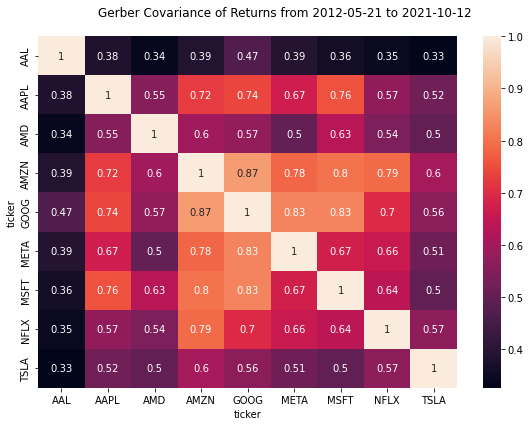

In [94]:
fig, axes = plt.subplots(figsize = (8, 6))

sns.heatmap(
    test_gerber.g_matrix, 
    annot = True,
    ax = axes)

fig.suptitle("Gerber Covariance of Returns from {} to {}".format(
    df.index.min().date(), df.index.max().date()))

plt.tight_layout()
plt.show()

## Make Rolling